In [1]:
import sys
sys.path.insert(0, '../')
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars


import vqe as vqelib
import annni_model as annni
import hamiltonians as ham
import ising_chain as ising_chain
import jax.profiler

# System parameters
N = 4
J = 1
l_steps = 100

# Learning parameters
lr = .25
epochs = 30000
reg = 250

In [2]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from jax.example_libraries import optimizers

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
import plotly.graph_objects as go
import pandas as pd
from orqviz.scans import perform_2D_scan, plot_2D_scan_result
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)


import copy
import tqdm  # Pretty progress bars
import joblib, pickle  # Writing and loading

import warnings

In [7]:
class vqe:
    def __init__(self, Hs, circuit):
        """
        Class for the VQE algorithm

        Parameters
        ----------
        Hs : class
            Custom Hamiltonian class
        circuit : function
            Function of the VQE circuit
        """
        self.N = Hs.N
        self.Hs = Hs
        self.n_states = Hs.n_states
        self.circuit = lambda p: circuit(self.N, p)
        self.n_params = self.circuit([0] * 10000)
        self.vqe_states = jnp.array(np.tile(np.random.rand(self.n_params), (self.n_states, 1)))
        self.device = qml.device("default.qubit.jax", wires=self.N, shots=None)
        self.MSE = []
        self.vqe_e = []
        self.recycle = False
        self.states_dist = []

        self.circuit_fun = circuit

    def show_circuit(self):
        """
        Prints the current circuit defined by self.circuit
        """

        @qml.qnode(self.device, interface="jax")
        def vqe_state(self):
            self.circuit(np.arange(self.n_params))

            return qml.state()

        drawer = qml.draw(vqe_state)
        print(drawer(self))

    def show_results_isingchain(self):
        """
        Shows results of a trained VQE run:
        > VQE enegies plot
        > Loss curve if VQE was trained using recycle = False
        > Final relative errors
        > Mean Squared difference between final subsequent states
        """
        self.states_dist = [
            np.mean(np.square(np.real(self.states[k + 1] - self.states[k])))
            for k in range(self.n_states - 1)
        ]
        
        lams = np.linspace(0, 2*self.Hs.J, self.n_states)
        
        tot_plots = 3 if self.recycle else 4
        fig, ax = plt.subplots(tot_plots, 1, figsize=(12, 18.6))

        ax[0].plot(lams, self.Hs.true_e, "--", label="True", color="red", lw=2)
        ax[0].plot(lams, self.vqe_e, ".", label="VQE", color="green", lw=2)
        ax[0].plot(lams, self.vqe_e, color="green", lw=2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title(
            "Ground States of Ising Hamiltonian ({0}-spins), J = {1}".format(
                self.N, self.Hs.J
            )
        )
        ax[0].set_xlabel(r"$\lambda$")
        ax[0].set_ylabel(r"$E(\lambda)$")
        ax[0].legend()

        k = 1
        if not self.recycle:
            ax[1].plot(
                np.arange(len(self.MSE)) * 100, self.MSE, ".", color="orange", ms=7
            )
            ax[1].plot(
                np.arange(len(self.MSE)) * 100, self.MSE, color="orange", alpha=0.4
            )
            ax[1].set_title("Convergence of VQE")
            ax[1].set_xlabel("Epoch")
            ax[1].set_ylabel("MSE")
            ax[1].grid(True)
            ax[1].axhline(y=0, color="r", linestyle="--")

            k = 2

        accuracy = np.abs((self.Hs.true_e - self.vqe_e) / self.Hs.true_e)
        ax[k].fill_between(
            lams, 0.01, max(np.max(accuracy), 0.01), color="r", alpha=0.3
        )
        ax[k].fill_between(
            lams, 0.01, min(np.min(accuracy), 0), color="green", alpha=0.3
        )
        ax[k].axhline(y=0.01, color="r", linestyle="--")
        ax[k].scatter(lams, accuracy)
        ax[k].grid(True)
        ax[k].set_title("Accuracy of VQE".format(self.N, self.Hs.J))
        ax[k].set_xlabel(r"$\lambda$")
        ax[k].set_ylabel(r"$|(E_{vqe} - E_{true})/E_{true}|$")

        ax[k + 1].set_title(
            "Mean square distance between consecutives density matrices"
        )
        ax[k + 1].plot(
            np.linspace(0, 2 * self.Hs.J, num=self.n_states - 1),
            self.states_dist,
            "-o",
        )
        ax[k + 1].grid(True)
        ax[k + 1].axvline(x=self.Hs.J, color="gray", linestyle="--")
        ax[k + 1].set_xlabel(r"$\lambda$")

        plt.tight_layout()

    def show_results_annni(self, log_heatmap = False):
        """
        Shows results of a trained VQE run:
        > VQE enegies plot
        > Loss curve if VQE was trained using recycle = False
        > Final relative errors
        > Mean Squared difference between final neighbouring states
        """
        states_dist = []
        side = int(np.sqrt(self.n_states))
        
        trues = np.reshape(self.Hs.true_e,(side, side) )
        preds = np.reshape(self.vqe_e,(side, side) )

        x = np.linspace(1, 0, side)
        y = np.linspace(0, 2, side)
        
        fig = go.Figure(data=[go.Surface(opacity=.2, colorscale='Reds', z=trues, x=x, y=y),
                      go.Surface(opacity=1, colorscale='Blues',z=preds, x=x, y=y)])

        fig.update_layout(height=500)
        fig.show()
        
        if not self.recycle:
            plt.figure(figsize=(15,3))
            plt.title('Loss of training set')
            plt.plot(np.arange(len(self.MSE)+1)[1:]*100, self.MSE)
            plt.show()
        
        accuracy = np.rot90( np.abs(preds-trues)/np.abs(trues) )
        
        fig2, ax = plt.subplots(1, 2, figsize=(10, 40))
        
        if not log_heatmap:
            colors_good = np.squeeze( np.dstack((np.dstack((np.linspace(.3,0,25), np.linspace(.8,1,25))), np.linspace(1,0,25) )) )
            colors_bad  = np.squeeze( np.dstack((np.dstack((np.linspace(1,0,100), [0]*100)), [0]*100 )) )
            colors = np.vstack((colors_good, colors_bad))
            cmap_acc = LinearSegmentedColormap.from_list('accuracies', colors)

            acc = ax[0].imshow(accuracy, cmap = cmap_acc)
            acc.set_clim(0,0.05)
            plt.colorbar(acc, ax=ax[0], fraction=0.04)
        else:
            colors = np.squeeze( np.dstack((np.dstack((np.linspace(0,1,75), np.linspace(1,0,75))), np.linspace(0,0,75) )) )
            cmap_acc = LinearSegmentedColormap.from_list('accuracies', colors)
            acc = ax[0].imshow(accuracy, cmap = cmap_acc, norm=LogNorm())
            plt.colorbar(acc, ax=ax[0], fraction=0.04)
        
        ax[0].set_xlabel('L')
        ax[0].set_ylabel('K')
        ax[0].set_title('Relative errors')
        
        ax[0].set_xticks(ticks=np.linspace(0,side-1,4).astype(int), labels= np.round(x[np.linspace(side-1,0,4).astype(int)],2))
        ax[0].set_yticks(ticks=np.linspace(0,side-1,4).astype(int), labels= np.round(y[np.linspace(side-1,0,4).astype(int)],2))
        
        for idx, state in enumerate(self.states):
            neighbours = np.array([idx + 1, idx - 1, idx + side, idx - side])
            neighbours = np.delete(neighbours, np.logical_not(np.isin(neighbours, self.Hs.recycle_rule)) )


            if (idx + 1) % side == 0 and idx != self.n_states - 1:
                neighbours = np.delete(neighbours, 0)
            if (idx    ) % side == 0 and idx != 0:
                neighbours = np.delete(neighbours, 1)

            states_dist.append(np.mean(np.square([np.real(self.states[n] - state) for n in neighbours]) ) )

        ax[1].set_title('Mean square difference between neighbouring states')
        diff = ax[1].imshow(np.rot90(np.reshape(states_dist, (side,side)) ) )
        plt.colorbar(diff, ax=ax[1], fraction=0.04)
        ax[1].set_xlabel('L')
        ax[1].set_ylabel('K')
        
        ax[1].set_xticks(ticks=np.linspace(0,side-1,4).astype(int), labels= np.round(x[np.linspace(side-1,0,4).astype(int)],2))
        ax[1].set_yticks(ticks=np.linspace(0,side-1,4).astype(int), labels= np.round(y[np.linspace(side-1,0,4).astype(int)],2))
        plt.tight_layout()
        
    def show_trajectory(self, idx):
        def loss(params):
            @qml.qnode(self.device, interface="jax")
            def vqe_state(vqe_params):
                self.circuit(vqe_params)

                return qml.state()

            pred_state = vqe_state(params)
            vqe_e = jnp.conj(pred_state) @ self.Hs.mat_Hs[idx] @ pred_state

            return jnp.real(vqe_e)

        trajs = []
        for traj in self.trajectory:
            trajs.append(traj[idx])

        dir1 = np.array([1., 0.])
        dir2 = np.array([0., 1.])

        pca = get_pca(trajs)
        scan_pca_result = perform_2D_pca_scan(pca, loss, n_steps_x=30)

        fig, ax = plt.subplots()
        plot_pca_landscape(scan_pca_result, pca, fig=fig, ax=ax)
        plot_optimization_trajectory_on_pca(trajs, pca, ax=ax, 
                                            label="Optimization Trajectory", color="lightsteelblue")
        plt.legend()
        plt.show()

    def train(self, lr, n_epochs, reg=0, circuit=False, recycle=True, save_trajectories = False, epochs_batch_size = 500):
        """
        Training function for the VQE.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        reg : float
            Regularizer of the training function. It ensures the subsequent states are not
            too much different
        circuit : bool
            if True -> Prints the circuit
            if False -> It does not display the circuit
        plots : bool
            if True -> Display plots
            if False -> It does not display plots
        recycle : bool
            if True -> Each state (depending on the intensity of the magnetic field) is computed independently and in parallel.
            if False -> Each state is trained after the previous one, in which the initial parameters are the final learnt parameters of the previous state
        """
        # IDEA: Making the Jax version of a VQE eigensolver is a bit less intuitive that in the QCNN learning function,
        #       since here we have l_steps different circuits since each output of the circuit is <psi|H|psi> where H,
        #       changes for each datapoint.
        #       Here the output of each circuit is |psi>, while the Hs is moved to the loss function
        #       <PSI|Hs|PSI> is computed through two jax.einsum

        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            self.show_circuit()

        ### JAX FUNCTIONS ###
        # Circuit that returns the state |psi>
        @qml.qnode(self.device, interface="jax")
        def vqe_state(vqe_params):
            self.circuit(vqe_params)

            return qml.state()
        
        def compute_true_state(H):
            # Compute eigenvalues and eigenvectors
            eigval, eigvec = jnp.linalg.eigh(H)
            # Get the eigenstate to the lowest eigenvalue
            gstate = eigvec[:,jnp.argmin(eigval)]

            return gstate

        jv_compute_true_state = jax.jit(jax.vmap(compute_true_state))
        true_states = jv_compute_true_state(self.Hs.mat_Hs)

        # vmap of the circuit
        v_vqe_state = jax.vmap(lambda v: vqe_state(v), in_axes=(0))

        # jitted vmap of the circuit
        jv_vqe_state = jax.jit(v_vqe_state)

        # jitted circuit
        j_vqe_state = jax.jit(lambda p: vqe_state(p))

        # computes <psi|H|psi>
        def compute_E(state, Hmat):
            return jnp.conj(state) @ Hmat @ state

        # vmapped function for <psi|H|psi>
        v_compute_E = jax.vmap(compute_E, in_axes=(0, 0))
        # jitted function for <psi|H|psi>
        j_compute_E = jax.jit(compute_E)

        # Same function as above but returns the energies not MSE
        def compute_vqe_E(param, Hmat):
            pred_states = j_vqe_state(param)
            vqe_e = j_compute_E(pred_states, Hmat)

            return jnp.real(vqe_e)

        j_compute_vqe_E = jax.jit(compute_vqe_E)
        v_compute_vqe_E = jax.vmap(compute_vqe_E, in_axes=(0, 0))

        # Same function as above but returns the energies not MSE
        def v_compute_vqe_E(params):
            pred_states = v_vqe_state(params)
            vqe_e = v_compute_E(pred_states, self.Hs.mat_Hs)

            return jnp.real(vqe_e)

        j_v_compute_vqe_E = jax.jit(v_compute_vqe_E)

        # Prepare initial parameters randomly for each datapoint/state
        # We start from the same datapoint
        params = copy.copy(self.vqe_states)

        if not recycle:
            self.recycle = False
            oom = False
            # Regularizator of the optimizer
            def compute_diff_states(states):
                return jnp.mean(jnp.square(jnp.diff(jnp.real(states), axis=1)))

            # Computes MSE of the true energies - vqe energies: function to minimize
            def fidelty_loss(params, true_state):
                state = vqe_state(params)
                fidelty = jnp.mean( jnp.square(jnp.abs( jnp.conj(state) @  true_state)) )

                return 1 - fidelty

            # Grad function of the MSE, used in updating the parameters
            loss = lambda p, t : jnp.mean(jax.jit(jax.vmap( fidelty_loss, in_axes = (0, 0) ))(p, t) )
            jd_loss = jax.jit(jax.grad(loss))
            
            def update(params, opt_state):
                grads = jd_loss(params, true_states)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 

            progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

            MSE = []
            self.trajectory = []
            
            # Defining an optimizer in Jax
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(params)
            
            for it in progress:
                params, opt_state = update(params, opt_state)
                
                # I want to skip when it == 0
                if (it + 1) % epochs_batch_size == 0:
                    if not oom:
                        try:
                            MSE.append(
                                jnp.mean(jnp.square(j_v_compute_vqe_E(params) - self.Hs.true_e))
                            )
                        except RuntimeError:
                            oom = True
                            MSE.append(
                                jnp.mean(jnp.square(v_compute_vqe_E(params) - self.Hs.true_e))
                            )
                    else:
                        MSE.append(
                                jnp.mean(jnp.square(v_compute_vqe_E(params) - self.Hs.true_e))
                            )

                    # Update progress bar
                    progress.set_description("Cost: {0}".format(MSE[-1]))
                
                if save_trajectories:
                    self.trajectory.append(params)
        else:
            self.recycle = True
            oom = False
            # Computes MSE of the true energies - vqe energies: function to minimize
            def loss_reg(param, Hmat, reg, previous_state):
                pred_state = j_vqe_state(param)
                vqe_e = j_compute_E(pred_state, Hmat)
                
                param_diff = jnp.mean(jnp.square(jnp.real(pred_state - previous_state)))
                
                return jnp.real(vqe_e) + reg * param_diff
            
            def loss(param, Hmat):
                pred_state = j_vqe_state(param)
                vqe_e = j_compute_E(pred_state, Hmat)
                
                return jnp.real(vqe_e)

            # Grad function of the MSE, used in updating the parameters
            jd_loss_reg = jax.jit(jax.grad(loss_reg))
            jd_loss = jax.jit(jax.grad(loss))
            
            def update(param, opt_state, Hmat):
                grads = jd_loss(param, Hmat)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 
            
            def update_reg(param, opt_state, Hmat, reg, previous_state):
                grads = jd_loss_reg(param, Hmat, reg, previous_state)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 

            progress = tqdm.tqdm(self.Hs.recycle_rule[1:], position=0, leave=True)
            params = [[0]*self.n_params]*self.n_states
            param = jnp.array(np.random.rand(self.n_params))
            
            MSE = []
            previous_pred_states = []
            
            idx = 0
            
            # Defining an optimizer in Jax
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(param)
            
            for it in range(10*n_epochs):
                param, opt_state = update(param, opt_state, self.Hs.mat_Hs[idx])
                
            previous_state = j_vqe_state(param)
            params[idx] = copy.copy(param)
            progress.set_description("{0}/{1}".format(idx + 1, self.n_states))
            
            for idx in (progress):
                opt_init, opt_update, get_params = optimizers.adam(lr)
                opt_state = opt_init(param)
                
                for it in range(n_epochs):
                    param, opt_state = update_reg(param, opt_state, self.Hs.mat_Hs[idx], reg, previous_state)
                        
                params[idx] = copy.copy(param)
                progress.set_description("{0}/{1}".format(idx + 1, self.n_states))
                previous_state = j_vqe_state(param)
            params = jnp.array(params)

        self.MSE = MSE
        self.vqe_states = params
        
        if not oom:
            self.vqe_e = j_v_compute_vqe_E(params)
            self.states = jv_vqe_state(params)
        else:
            self.vqe_e = v_compute_vqe_E(params)
            self.states = v_vqe_state(params)

    def save(self, filename):
        """
        Save main parameters of the VQE class to a local file.
        Parameters saved:
        > Hs class, vqe parameters, circuit function

        Parameters
        ----------
        filename : str
            Local file to save the parameters
        """
        things_to_save = [
            self.Hs,
            self.vqe_states,
            self.circuit_fun
        ]

        with open(filename, "wb") as f:
            pickle.dump(things_to_save, f)


def load_vqe(filename):
    """
    Load main parameters of a VQE class saved to a local file using vqe.save(filename)

    Parameters
    ----------
    filename : str
        Local file from where to load the parameters

    Returns
    -------
    class
        VQE class with main parameters
    """
    with open(filename, "rb") as f:
        things_to_load = pickle.load(f)

    Hs, vqe_states, circuit_fun = things_to_load

    loaded_vqe = vqe(Hs, circuit_fun)
    loaded_vqe.vqe_states = vqe_states
    
    return loaded_vqe

In [47]:
import PhaseEstimation.circuits as circuits

In [48]:
Hs = ham.hamiltonian(ising_chain.build_Hs, N = N, J = J, n_states = l_steps)

In [49]:
myvqe = vqe(Hs, circuit)

In [50]:
myvqe.train(.3, 10000, circuit = False, recycle = False, reg = reg)

[[0.35355344+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.35355347+0.j]
 [0.36442244+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.3429912 +0.j]
 [0.37560853+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.3327233 +0.j]
 ...
 [0.975067  +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.01608982+0.j]
 [0.97558236+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.01576785+0.j]
 [0.9760819 +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.01545538+0.j]]


Cost: 0.1116080954670906: 100%|██████████| 10000/10000 [00:20<00:00, 493.98it/s]


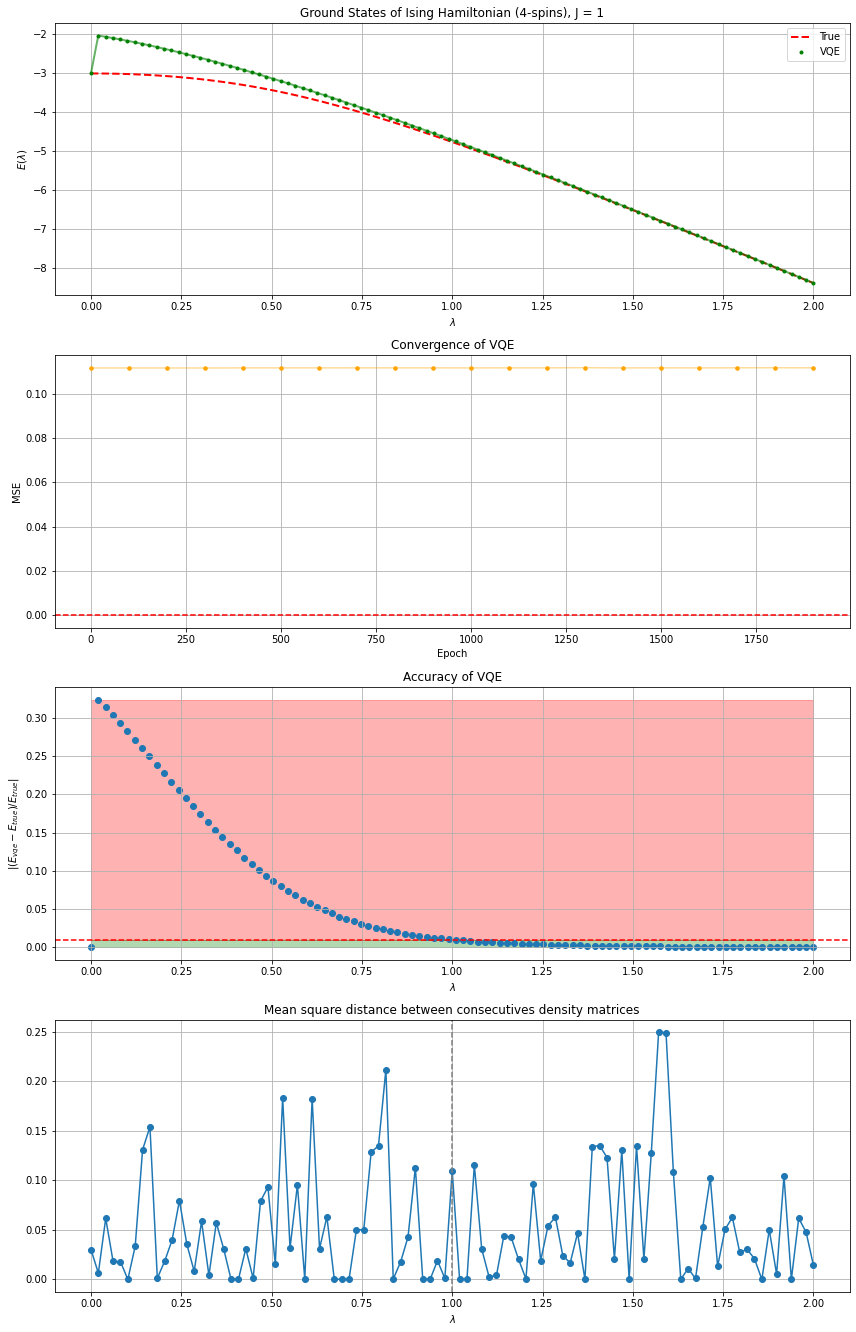

In [45]:
myvqe.show_results_isingchain()

In [30]:
@qml.qnode(myvqe.device, interface="jax")
def vqe_state(vqe_params):
    myvqe.circuit(vqe_params)

    return qml.state()

 # vmap of the circuit
v_vqe_state = jax.vmap(lambda v: vqe_state(v), in_axes=(0))

# jitted vmap of the circuit
jv_vqe_state = jax.jit(v_vqe_state)

def fidelty_loss(param, true_state):
    state = vqe_state(param)
    fidelty = jnp.mean( jnp.square(jnp.abs( jnp.conj(state) @  true_state)) )
    
    return 1 - fidelty

jv_fidelty_loss = jax.jit(jax.vmap( fidelty_loss, in_axes = (0, 0) ))

In [31]:
def compute_fidelty():
    
    def compute_true_state(H):
        # Compute eigenvalues and eigenvectors
        eigval, eigvec = jnp.linalg.eigh(H)
        # Get the eigenstate to the lowest eigenvalue
        gstate = eigvec[:,jnp.argmin(eigval)]

        return gstate

    jv_compute_true_state = jax.jit(jax.vmap(compute_true_state))
    true_states = jv_compute_true_state(myvqe.Hs.mat_Hs)
    
    return true_states

true_e = compute_fidelty()

In [32]:
jv_fidelty_loss(myvqe.vqe_states, true_e)

DeviceArray([0.49999976, 0.48600662, 0.47170335, 0.46972054, 0.44356966,
             0.44939756, 0.41396213, 0.40108234, 0.384906  , 0.37069672,
             0.35559416, 0.3424558 , 0.32686377, 0.312369  , 0.29699796,
             0.2824859 , 0.26838624, 0.25464904, 0.23974067, 0.22711295,
             0.212538  , 0.20002222, 0.18753803, 0.17458779, 0.16298926,
             0.15198857, 0.14084387, 0.13086301, 0.12125242, 0.11333543,
             0.10467201, 0.09573746, 0.08917397, 0.08177125, 0.0762592 ,
             0.0708726 , 0.06389374, 0.06056941, 0.05473238, 0.0507648 ,
             0.04636157, 0.04303259, 0.0394156 , 0.036865  , 0.03371185,
             0.03532255, 0.03025961, 0.02748781, 0.02632147, 0.02402931,
             0.02162665, 0.02025849, 0.01862961, 0.01788867, 0.01640332,
             0.01506096, 0.01426202, 0.01514012, 0.0123387 , 0.01170683,
             0.01115012, 0.01029223, 0.00968826, 0.00922215, 0.01706755,
             0.00793201, 0.00886399, 0.00709212, 0.